# Adaptive Learning with NV Centers

## Import Modules

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from __future__ import division # Ensures that a/b is always a float.
from IPython.display import display, clear_output

import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m
import abc
import datetime
from time import sleep
from adaptive import *
from nvdata import *
import socket
import scipy.stats as st

/Users/ihincks/anaconda/envs/nvadapt/lib/python2.7/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/ihincks/.matplotlib/stylelib/ggplot-rq.mplstyle: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(message)


## Setup

Connect to the server that sends experiments to the lab. Make sure it is waiting to accept connection when you run this.

In [2]:
job_client = TCPClient('129.97.136.46', 50000)
job_client.connect()
results_client = TCPClient('129.97.136.46', 50001)
results_client.connect()

Connect to the parallel engines of this computer.

In [3]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = False
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

## Initialize Prior and Sweeps

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

In [5]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.25])
target_stds = np.array([0.01,0.005,0.01,0.005,0.01])
wide_prior = qi.ProductDistribution(
        qi.UniformDistribution(np.array([
            [0,20],
            [0,10],
            [-5,5],
            [1.5,3.5]
        ])),
    m.InverseUniform([[1,20]])
    )

# this prior will not actually be used; we will use an empirical
# prior found in the class TrackingHeuristic
ref_prior = qi.UniformDistribution(
    [[0.019,0.021],[0.014,0.016]]
)

drift_prior = m.DriftDistribution(0.00001, r=0.7, nu=30)

In [6]:
ham_model = m.RabiRamseyModel()
ref_model = m.ReferencedPoissonModel(ham_model)

## Heuristic Testing with Experimental Data

This is a copy of the physical hardware that runs experiments:

In [7]:
experiment = TCPRabiRamseyExperimentRunner(job_client, results_client)

We will try and always choose `n_meas` to end up with the following number of effective bits.

In [8]:
eff_num_bits = 20
drift_tracking = True

A helper function to instantiate new updaters (note the wide_prior, and 10000 particles):

In [9]:
def make_updater():
    def  scale(expparam):
        # assume 2 seconds of data-transfer overhead
        return compute_run_time(expparam) + 2
    model = qi.GaussianRandomWalkModel(
            qi.DirectViewParallelizedModel(
            m.ReferencedPoissonModel(m.RabiRamseyModel()),
            dview, 
            serial_threshold=1
        ),
        random_walk_idxs=[5,6],
        diagonal=False,
        scale_mult=scale
    )
    updater = m.BridgedRPMUpdater(model, 10000, qi.ProductDistribution(wide_prior, ref_prior, drift_prior))
    #updater = qi.SMCUpdater(model, 10000, qi.ProductDistribution(wide_prior, drift_prior))
    return updater

<IPython.core.display.Javascript object>


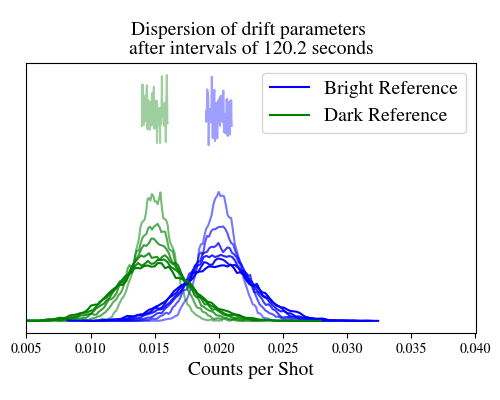

Skipping ../fig/drift-dispersion.png
Skipping ../fig/drift-dispersion.pdf


In [10]:
u = make_updater()

eps = rabi_sweep(n_meas=4275000)[np.newaxis,0]

fig = plt.figure(figsize=(5,4))
for idx in range(7):
    a = np.sqrt((idx+1)/7)
    lab = 'Bright Reference' if idx==6 else None
    u.plot_posterior_marginal(5, other_plot_args=dict(alpha=a, color='b', label=lab))
    lab = 'Dark Reference' if idx==6 else None
    u.plot_posterior_marginal(6, other_plot_args=dict(alpha=a, color='g', label=lab))
    u.particle_locations = u.model.update_timestep(u.particle_locations, eps)[:,:,0]
    
plt.title('Dispersion of drift parameters \nafter intervals of {0:.1f} seconds'.format(compute_run_time(eps)+2))
plt.xlabel('Counts per Shot')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.xlim([0.005,0.04])

export_figure(fig, 'drift-dispersion')

### Linear Heuristic

The linear heuristic consists of alternating between Rabi and Ramsey experiments, where the pulsing time of the Ramsey experiment is based on the current best estimate of the rabi strength.

In [ ]:
n_trials = 100
n_eps = 200

panel_linear = HeuristicData('../data/alternating_linear_final.pkl')

def make_heuristic():
    return TrackingHeuristic(
        LinearHeuristic(make_updater(), max_t=1, max_tau=2, n=int(n_eps/2)),
        std_tracking=5,
        track_on_initial_reference=True,
        std_mult=3,
        eff_num_bits=eff_num_bits
    )

for idx_trial in range(panel_linear.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(
                heuristic, old_eps, old_job.get_result(), 
                old_precede_by_tracking, drift_tracking=drift_tracking
            )
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(
        heuristic, eps, job.get_result(), 
        old_precede_by_tracking, drift_tracking=drift_tracking
    )
    df = append_experiment_data(df, 
        expparam=old_eps, 
        heuristic=heuristic, 
        job=job,
        heuristic_value=None
    )
        
    # save results in panel
    panel_linear.append(df)
    panel_linear.save()

### Classic Linear

Current Trial: 69


<IPython.core.display.Javascript object>


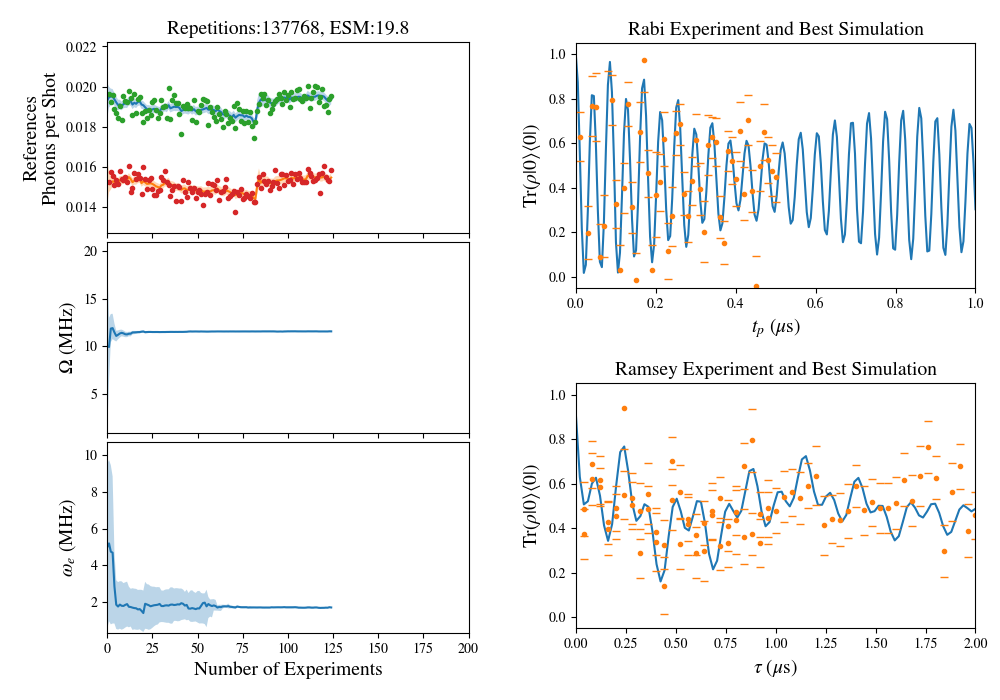

In [ ]:
n_trials = 100
n_eps = 200

panel_linear = HeuristicData('../data/classic_linear_final.pkl')
rabi_eps = np.concatenate([rabi_sweep(max_t=0.5, n=50, n_meas=10)]*1)
ramsey_eps = np.concatenate([ramsey_sweep(max_tau=2, n=50, n_meas=10)]*3)


def make_heuristic():
    return TrackingHeuristic(
        PredeterminedSingleAdaptHeuristic(make_updater(), rabi_eps, ramsey_eps),
        std_tracking=5,
        track_on_initial_reference=True,
        std_mult=3,
        eff_num_bits=eff_num_bits
    )

for idx_trial in range(panel_linear.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(
                heuristic, 
                old_eps, 
                old_job.get_result(), 
                old_precede_by_tracking, 
                drift_tracking=drift_tracking
            )
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_linear.append(df)
    panel_linear.save()

### Bernoulli Risk Heuristic 11111

In [ ]:
n_trials = 100
n_eps = 200

panel_beurnoulli_risk = HeuristicData('../data/bernoulli_risk_new_new.pkl')

def make_heuristic():
    return TrackingHeuristic(
        RiskHeuristic(
            make_updater(), 
            [1,1,1,1,1], 
            rabi_sweep(max_t=1, n=int(n_eps/2), n_meas=n_meas), 
            ramsey_sweep(max_tau=2, n=int(n_eps/2), n_meas=n_meas),
            dview=dview
        ),
        cutoff=0.85,
        track_on_initial_reference=True,
        std_mult=3
    )

for idx_trial in range(panel_beurnoulli_risk.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(heuristic, old_eps, old_job.get_result(), old_precede_by_tracking)
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_beurnoulli_risk.append(df)
    panel_beurnoulli_risk.save()

### Bernoulli Risk: High Resolution

Current Trial: 27


<IPython.core.display.Javascript object>


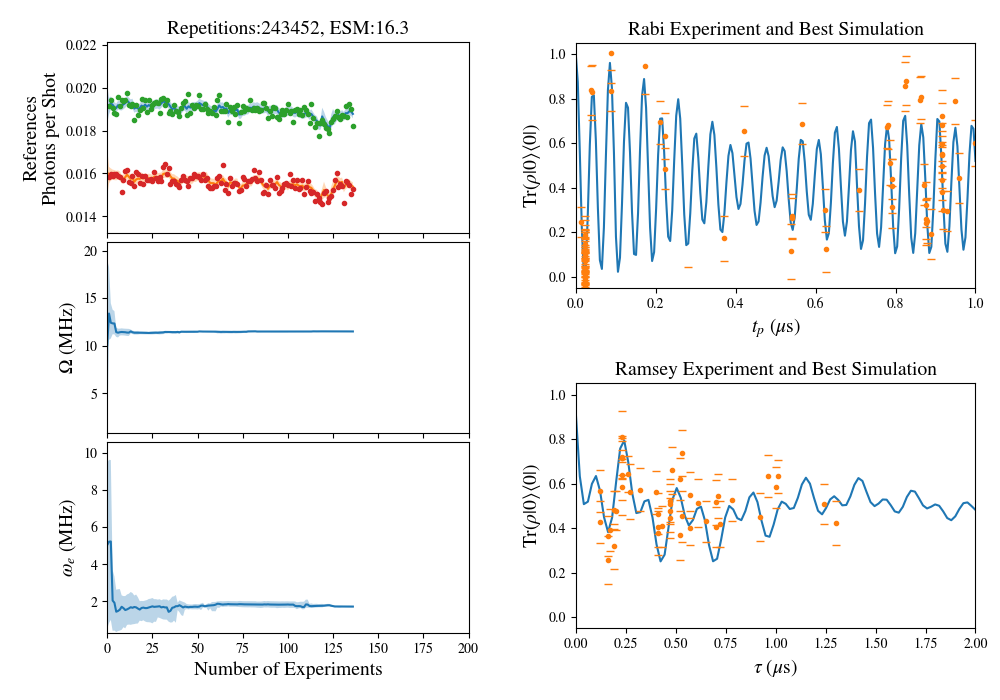

In [ ]:
n_trials = 100
n_eps = 200

panel_beurnoulli_risk = HeuristicData('../data/bernoulli_risk_high_res.pkl')

def make_heuristic():
    return TrackingHeuristic(
        RiskHeuristic(
            make_updater(), 
            [1,1,1,1,1], 
            rabi_sweep(max_t=1, n=500, n_meas=1), 
            ramsey_sweep(max_tau=2, n=200, n_meas=1),
            dview=dview, 
            subsample_particles=2000
        ),
        std_tracking=5,
        track_on_initial_reference=True,
        std_mult=3,
        eff_num_bits=eff_num_bits
    )

for idx_trial in range(panel_beurnoulli_risk.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(
                heuristic, 
                old_eps, 
                old_job.get_result(), 
                old_precede_by_tracking, 
                drift_tracking=drift_tracking
            )
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_beurnoulli_risk.append(df)
    panel_beurnoulli_risk.save()

### Thomas' QRisk

Current Trial: 0


<IPython.core.display.Javascript object>


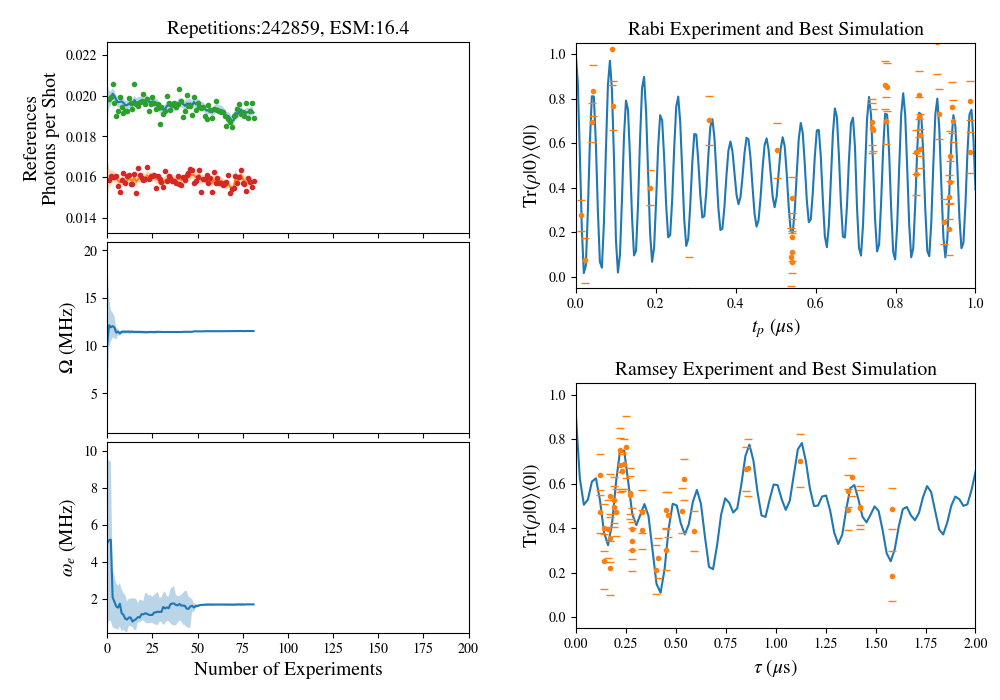

/Users/ihincks/anaconda/envs/nvadapt/lib/python2.7/site-packages/matplotlib/gridspec.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
vexpm.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  out[j] = np.dot(a[j], b[j])


In [ ]:
n_trials = 100
n_eps = 200

panel_beurnoulli_risk = HeuristicData('../data/bernoulli_qrisk.pkl')

def make_heuristic():
    return TrackingHeuristic(
        QPriorRiskHeuristic(
            make_updater(), 
            [1,1,1,1,1], 
            rabi_sweep(max_t=1, n=500, n_meas=1), 
            ramsey_sweep(max_tau=2, n=200, n_meas=1),
            dview=dview, 
            subsample_particles=2000
        ),
        std_tracking=5,
        track_on_initial_reference=True,
        std_mult=3,
        eff_num_bits=eff_num_bits
    )

for idx_trial in range(panel_beurnoulli_risk.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(
                heuristic, 
                old_eps, 
                old_job.get_result(), 
                old_precede_by_tracking, 
                drift_tracking=drift_tracking
            )
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_beurnoulli_risk.append(df)
    panel_beurnoulli_risk.save()

### Power Curve Data

In [ ]:
class PowerCurveRunner(TCPRabiRamseyExperimentRunner):
    def __init__(self, job_client, results_client):
        super(PowerCurveRunner, self).__init__(job_client, results_client)
        self.pulse_power = 0
        
    def make_job_string(self, **kwargs):
        kwargs['pulse1_power'] = self.pulse_power
        kwargs['pulse2_power'] = self.pulse_power
        return TCPRabiRamseyExperimentRunner.make_job_string(**kwargs)
    
power_experiment = PowerCurveRunner(job_client, results_client)

In [ ]:
linear_powers = np.linspace(0, 1, 16)[1:]
db_powers = 20 * np.log10(linear_powers)

n_powers = db_powers.size
n_eps = 200

panel_power_curve = HeuristicData('../data/power_curve.pkl')

def make_heuristic():
    return TrackingHeuristic(
        LinearHeuristic(make_updater(), max_t=1, max_tau=2, n=int(n_eps/2), n_meas=n_meas),
        cutoff=0.85,
        track_on_initial_reference=True,
        std_mult=3
    )

for idx_trial in range(panel_power_curve.n_dataframes, n_powers):
    db_power = db_powers[idx_trial]
    power_experiment.pulse_power = db_power
    
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(power_experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = power_experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(heuristic, old_eps, old_job.get_result(), old_precede_by_tracking)
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=db_power
        )
        
    # save results in panel
    panel_power_curve.append(df)
    panel_power_curve.save()

### Transfer Function Data

In [ ]:
offsets = np.linspace(-15, 15, 7)
n_offsets = offsets.size
n_eps = 200

panel_transfer_function = HeuristicData('../data/transfer_function_new.pkl')

def make_heuristic():
    return TrackingHeuristic(
        LinearHeuristic(make_updater(), max_t=1, max_tau=2, n=int(n_eps/2), n_meas=n_meas),
        cutoff=0.85,
        track_on_initial_reference=True,
        std_mult=3
    )

for idx_trial in range(panel_transfer_function.n_dataframes, n_offsets):
    offset = offsets[idx_trial]
    
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    eps['wo'] = offset
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job if idx_eps > 0 else None
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(heuristic, old_eps, old_job.get_result(), old_precede_by_tracking)
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
            eps['wo'] = offset
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_transfer_function.append(df)
    panel_transfer_function.save()

### Bernoulli Risk 11000

In [ ]:
n_trials = 50
n_eps = 200

panel_beurnoulli_risk = HeuristicData('../data/bernoulli_risk_11000.pkl')

def make_heuristic():
    return TrackingHeuristic(
        RiskHeuristic(
            make_updater(), 
            [1,1,0,0,0], 
            rabi_sweep(max_t=0.5, n=int(n_eps/2), n_meas=n_meas), 
            ramsey_sweep(max_tau=2, n=int(n_eps/2), n_meas=n_meas),
            dview=dview
        ),
        cutoff=0.85,
        track_on_initial_reference=True,
        std_mult=3
    )

for idx_trial in range(panel_beurnoulli_risk.n_dataframes, n_trials):
    # construct heuristic and initialize reference prior empirically
    heuristic = make_heuristic()
    heuristic.take_initial_reference(experiment)
    
    # construct storage object for this trial
    df = new_experiment_dataframe(heuristic)
    clear_output()
    print 'Current Trial: {}'.format(idx_trial)
    liveView = DataFrameLiveView(df)
    liveView.fig
    
    # decide on first experiment
    tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
    eps, precede_by_tracking = heuristic(tp_est)
    
    for idx_eps in range(n_eps):
        
        # submit experiment job
        old_job = job
        job = experiment.run_experiment(eps, precede_by_tracking)

        # analyze latest data (from previous loop iteration) while running next job
        if idx_eps > 0:
            # update current state of knowledge with latest results
            perform_update(heuristic, old_eps, old_job.get_result(), old_precede_by_tracking)
            
            # store results
            df = append_experiment_data(df, 
                    expparam=old_eps, 
                    heuristic=heuristic, 
                    job=old_job,
                    heuristic_value=None
                )
            
            # print current status
            liveView.df = df
            liveView.update()
        
        # decide on next experiment while running current job
        if idx_eps < n_eps - 1:
            old_eps = eps
            old_precede_by_tracking = precede_by_tracking
            tp_est = np.round(1 / heuristic.updater.est_mean()[0] / 4 / 0.002) * 0.002
            eps, precede_by_tracking = heuristic(tp_est)
        
        # wait for job to complete
        while not job.is_complete:
            sleep(0.2)

    # one last update because of the weird ordering of the previous loop
    # that was necessary to do stuff while jobs were running
    perform_update(heuristic, eps, job.get_result(), precede_by_tracking)
    df = append_experiment_data(df, 
            expparam=old_eps, 
            heuristic=heuristic, 
            job=job,
            heuristic_value=None
        )
        
    # save results in panel
    panel_beurnoulli_risk.append(df)
    panel_beurnoulli_risk.save()